### Algorithm

1. Read the dataset.
2. Reshape the dataset
2. Split the dataset to:
    * 70% training (only contain normal data),
    * 10% validation (contain normal and anomaly data), and
    * 20% testing dataset (contain normal and anomaly data)
3. Create autoencoder model.
4. Train the model using training dataset.
5. Validate the model using validation dataset.
6. Test the model using testing dataset.

### Requirements

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


### Hyperparameters

In [2]:
window_size = 15
value_range = (0, 40000)

test_size = 0.25
random_state = 11

# Define model's hyperparameters
hidden_size = 64
output_size = 1
num_epochs = 4000
batch_size = 32
learning_rate = 0.001

### Helper Functions

In [3]:
def plot_anomaly(df, label='anomaly', plot_item='value', time_col='timestamp'):
    # Create sections
    sections = list()
    state = df.iloc[0][label]
    start = 0
    for i in df.index:
        if df.loc[i][label] != state:
            state = df.loc[i][label]
            sections.append(df.loc[start:i].copy(deep=True))
            start = i
    sections.append(df.loc[start:].copy(deep=True))

    # Plot sections
    plt.close()
    plt.figure().set_figwidth(20)
    for s in sections:
        # Change index
        s.index = s[time_col]

        color = 'blue' if s.iloc[0][label] == 0 else 'red'
        # plt.plot(s.index, s[plot_item], color=color)
        plt.scatter(s.index, s[plot_item], color=color)

    plt.show()


def plot_cm(cm):
    plt.close()
    # plt.figure(figsize=(8,8))
    # sns.set(font_scale = 1.5)

    ax = sns.heatmap(
        cm, # confusion matrix 2D array 
        annot=True, # show numbers in the cells
        fmt='d', # show numbers as integers
        xticklabels=[0,1],
        yticklabels=[0,1],
        # cbar=False, # don't show the color bar
        # cmap='flag', # customize color map
        # vmin=200, # to get better color contrast
        # vmax=800 # to get better color contrast
    )

    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    plt.show()



def show_matrix(y, y_pred):
    ps = precision_score(y, y_pred, pos_label=1, labels=[0, 1])
    print("precision_score: %.2f" % ps)

    rs = recall_score(y, y_pred, pos_label=1, labels=[0, 1])
    print("recall_score: %.2f" % rs)

    f1 = f1_score(y, y_pred, pos_label=1, labels=[0, 1])
    print("f1_score: %.2f" % f1)

    cm = confusion_matrix(y, y_pred, labels=[0, 1])
    # print("conf_matrix")
    # print(cm)
    plot_cm(cm)

### Preparing dataset

In [4]:
# Read the dataset
raw = pd.read_csv('/nas.dbms/mahendra.data/Documents/annotation/NAB/data/realKnownCause/nyc_taxi.csv',low_memory=False)
raw['timestamp'] = pd.to_datetime(raw['timestamp'])


# The times of anomaly events (Ground Truth)
anomaly_points = [
        [
            "2014-11-01 06:00:00.000000",
            "2014-11-02 06:00:00.000000"
        ],
        [
            "2014-11-27 06:00:00.000000",
            "2014-11-28 06:00:00.000000"
        ],
        [
            "2014-12-25 06:00:00.000000",
            "2014-12-26 06:00:00.000000"
        ],
        [
            "2014-12-31 06:00:00.000000",
            "2015-01-01 06:00:00.000000"
        ],
        [
            "2015-01-26 16:00:00.000000",
            "2015-01-28 05:00:00.000000"
        ]
]

# Normal label: 0, Anomaly label: 1
raw['anomaly'] = 0  # Set default values
for start, end in anomaly_points:
    raw.loc[((raw['timestamp'] >= start) & (raw['timestamp'] <= end)), 'anomaly'] = 1

In [5]:
print(raw.head())
print("\nDataset size:")
print(raw.shape)
print("\nDataset distribution:")
print(raw['anomaly'].value_counts())

            timestamp  value  anomaly
0 2014-07-01 00:00:00  10844        0
1 2014-07-01 00:30:00   8127        0
2 2014-07-01 01:00:00   6210        0
3 2014-07-01 01:30:00   4656        0
4 2014-07-01 02:00:00   3820        0

Dataset size:
(10320, 3)

Dataset distribution:
0    10049
1      271
Name: anomaly, dtype: int64


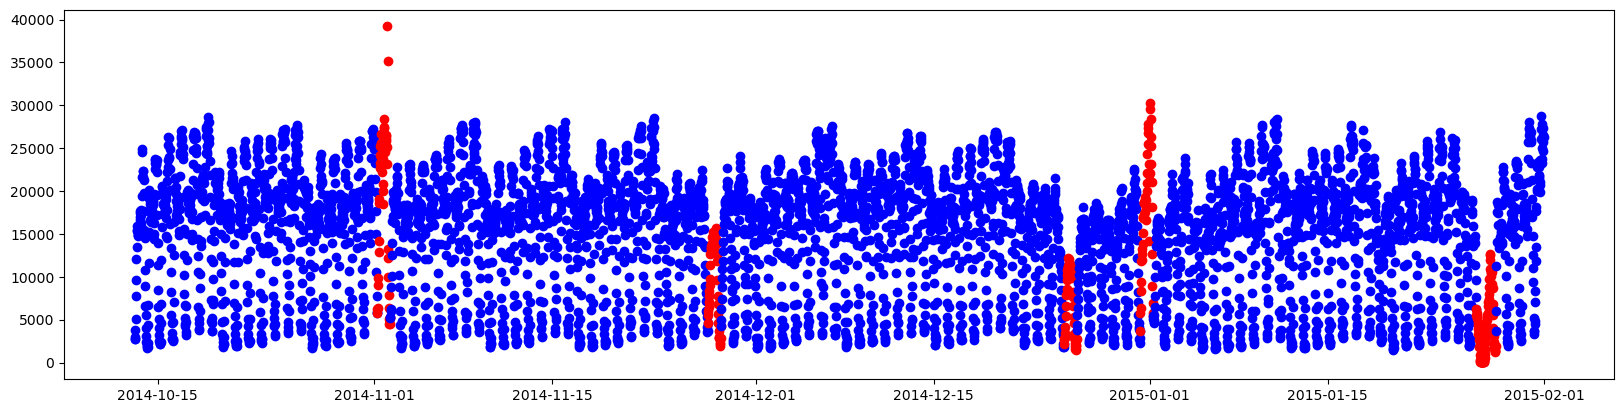

In [6]:
plot_anomaly(raw[5000:])

In [7]:
row = int(raw.shape[0]/window_size)
col = window_size

# Convert from pandas to numpy
X = raw['value'].to_numpy()
y = raw['anomaly'].to_numpy()

# Reshape
X = X.reshape((row, col))  # shape: (num_samples, num_features)
y = y.reshape((row, col))  # shape: (num_samples,)

# Normalization
X = (X - value_range[0]) / (value_range[1] - value_range[0])

# Calculate the median of the labels
y = np.round(np.mean(y, axis=1))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state,)

print("Training dataset")
print("X shape:", X_train.shape)
print("y shape:", y_train.shape)
print("Anomaly distribution:")
print(pd.Series(y_train).value_counts())

print("\nTesting dataset")
print("X shape:", X_test.shape)
print("y shape:", y_test.shape)
print("Anomaly distribution:")
print(pd.Series(y_test).value_counts())

Training dataset
X shape: (516, 15)
y shape: (516,)
Anomaly distribution:
0.0    502
1.0     14
dtype: int64

Testing dataset
X shape: (172, 15)
y shape: (172,)
Anomaly distribution:
0.0    167
1.0      5
dtype: int64


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Define the MLP model
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.fcOut = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fcOut(out)
        return out


def predict(model, features_tensor):
    with torch.no_grad():
        model.eval()
        train_outputs = model(features_tensor)
        return torch.round(torch.sigmoid(train_outputs)).squeeze().cpu().numpy()


# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

# Define input size
input_size = X_train.shape[1]

# Create the MLP model
model = MLPClassifier(input_size, hidden_size, output_size).to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create a TensorDataset and DataLoader
dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

progress_bar = tqdm(range(num_epochs),ncols=150)
progress_bar.set_description("Training")
for epoch in progress_bar:
    # Set the model in training mode
    model.train()

    for batch_features, batch_labels in dataloader:
        # Move batch to GPU
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        
        # Forward pass
        outputs = model(batch_features)

        # Calculate loss
        loss = criterion(outputs.squeeze(), batch_labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss after each epoch
    progress_bar.set_postfix(Loss="%.4f" % loss.item())


# Train prediction
train_predictions = predict(model, X_train_tensor)

# Test prediction
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
test_predictions = predict(model, X_test_tensor)


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:58<00:00, 67.82it/s, Loss=0.0000]


precision_score: 1.00
recall_score: 1.00
f1_score: 1.00


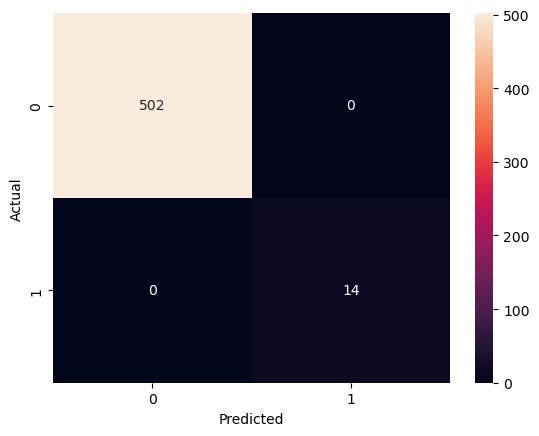

In [10]:
show_matrix(y_train, train_predictions)

precision_score: 1.00
recall_score: 0.40
f1_score: 0.57


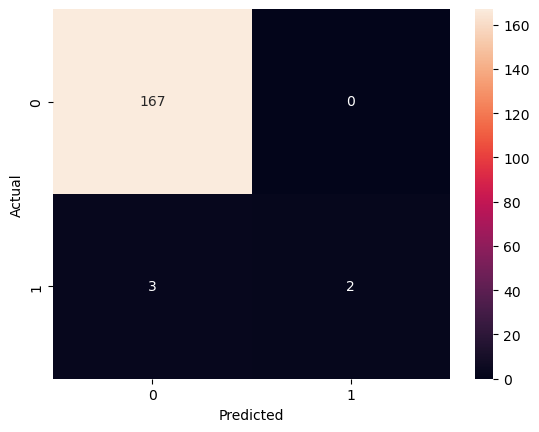

In [11]:
show_matrix(y_test, test_predictions)